# Mask R-CNN - Train on Shapes Dataset


This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)

tf.reset_default_graph()
# Root directory of the project
#ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
#sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
from mrcnn.utils import compute_overlaps_masks
import mrcnn.model_resnet50_unet as modellib
from mrcnn import visualize
from mrcnn.model_resnet50_unet import log
from PIL import Image
import yaml

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = "./logs"

# Local path to trained weights file
COCO_MODEL_PATH = "./logs/mask_rcnn_last_resnet50_unet.h5"
# Download COCO trained weights from Releases if needed
'''if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)'''
    
iter_num = 0

C:\Users\USER\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


## Configurations

In [2]:
class InferenceConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 6  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 768 #832 #512
    IMAGE_MAX_DIM = 768 #832 #512

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8*6, 16*6, 32*6, 64*6, 128*6)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 200

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 40
    
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  768
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  768
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [768 768   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 32
MASK_SHAPE                     [32, 32]
MAX_GT_INSTANCES

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

## Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [4]:
class DrugsDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """
    def get_obj_index(self, image):
        n = np.max(image)
        return n
    
    def from_yaml_get_class(self, image_id):
        info = self.image_info[image_id]
        with open(info['yaml_path']) as f:
            temp = yaml.load(f.read())
            labels = temp['label_names']
            del labels[0]
        return labels
    
    def draw_mask(self, num_obj, mask, image,image_id):
        #print("draw_mask-->",image_id)
        #print("self.image_info",self.image_info)
        info = self.image_info[image_id]
        #print("info-->",info)
        #print("info[width]----->",info['width'],"-info[height]--->",info['height'])
        for index in range(num_obj):
            for i in range(info['width']):
                for j in range(info['height']):
                    #print("image_id-->",image_id,"-i--->",i,"-j--->",j)
                    #print("info[width]----->",info['width'],"-info[height]--->",info['height'])
                    at_pixel = image.getpixel((i, j))
                    if at_pixel == index + 1:
                        mask[j, i, index] = 1
        return mask
    
    '''def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)'''
    
    def load_shapes(self, count, height,width,img_floder, mask_floder, imglist, dataset_root_path):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "leaf")# 黑色素瘤
        #self.add_class("shapes", 2, "Plaque")
        self.add_class("shapes", 2, "root")
        self.add_class("shapes", 3, "lyellow")
        self.add_class("shapes", 4, "lgreen")
        self.add_class("shapes", 5, "rgreen")
        self.add_class("shapes", 6, "rwhite")
        #self.add_class("shapes", 1, "butterfly")# 黑色素瘤
        #self.add_class("shapes", 2, "eyespot")
        for i in range(count):
            # 获取图片宽和高
            filestr = imglist[i].split(".")[0]
            #print(imglist[i],"-->",cv_img.shape[1],"--->",cv_img.shape[0])
            #print("id-->", i, " imglist[", i, "]-->", imglist[i],"filestr-->",filestr)
            # filestr = filestr.split("_")[1]
            mask_path = mask_floder + "/" + filestr + ".png"
            yaml_path = dataset_root_path + "labelme_json_graduate/" + filestr + "_json/info.yaml"
            #yaml_path = dataset_root_path + "test_annot/"+ "info.yaml"
            #print(dataset_root_path + "labelme_json/" + filestr + "_json/img.png")
            #cv_img = cv2.imread(dataset_root_path + "labelme_json/" + filestr + "_json/img.png")

            self.add_image("shapes", image_id=i, path=img_floder + "/" + imglist[i],
     
                        width=width, height=height, mask_path=mask_path, yaml_path=yaml_path)
            
    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        global iter_num
        #print("image_id",image_id)
        info = self.image_info[image_id]
        count = 1  # number of object
        img = Image.open(info['mask_path'])
        num_obj = self.get_obj_index(img)
        mask = np.zeros([info['height'], info['width'], num_obj], dtype=np.uint8)
        mask = self.draw_mask(num_obj, mask, img,image_id)
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count - 2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion


            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        labels = []
        labels = self.from_yaml_get_class(image_id)
        labels_form = []
        for i in range(len(labels)):
            if labels[i].find("leaf") != -1:
                # print "box"
                labels_form.append("leaf")
            elif labels[i].find("root") != -1:
                # print "box"
                labels_form.append("root")
            elif labels[i].find("lyellow") != -1:
                # print "box"
                labels_form.append("lyellow")
            elif labels[i].find("lgreen") != -1:
                # print "box"
                labels_form.append("lgreen")
            elif labels[i].find("rgreen") != -1:
                # print "box"
                labels_form.append("rgreen")
            elif labels[i].find("rwhite") != -1:
                # print "box"
                labels_form.append("rwhite")
        class_ids = np.array([self.class_names.index(s) for s in labels_form])
        return mask, class_ids.astype(np.int32)

    '''def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image'''
    
    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    '''def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)'''
    

    '''def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image'''
    
    
    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes


In [5]:
dataset_root_path="./"
img_floder = dataset_root_path + "flower_graduate"
mask_floder = dataset_root_path + "cv2_mask_graduate"
#yaml_floder = dataset_root_path
imglist = os.listdir(img_floder)
#print(imglist)
w_t_train = []
'''for i in range(0,291):
    w_t_train.append(str(i)+'.png')'''
train_count = len(imglist)
# Training dataset
dataset_train = DrugsDataset()
dataset_train.load_shapes(train_count,768,768,img_floder, mask_floder, imglist,dataset_root_path)
dataset_train.prepare()

# Validation dataset
dataset_val = DrugsDataset()
dataset_val.load_shapes(412,768,768,img_floder, mask_floder, imglist,dataset_root_path)
dataset_val.prepare()

In [6]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 88)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

FileNotFoundError: [Errno 2] No such file or directory: './labelme_json_graduate_test/451_json/info.yaml'

## Ceate Model

In [6]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)
model.keras_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, None, None, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNorm)            (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [14]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights('./logs/mask_rcnn_last_resnet50_unet_graduate.h5', by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [7]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1000, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/zxc44052000/data/Mask_RCNN-master/logs/mask_rcnn_last_resnet50_unet_test.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv1-1     (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_mask_conv3-1     (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_mask_conv4-1     (TimeDistributed)
mrcnn_mask_conv5       (TimeDistributed)
mrcnn_mask_bn5         (TimeDistributed)
mrcnn_mask_conv5-1   

C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/1000
 63/200 [========>.....................] - ETA: 20:01 - loss: 4.2129 - rpn_class_loss: 0.6085 - rpn_bbox_loss: 2.0160 - mrcnn_class_loss: 0.2876 - mrcnn_bbox_loss: 0.7084 - mrcnn_mask_loss: 0.5923

ERROR:root:Error processing image {'id': 445, 'source': 'shapes', 'path': './flower_graduate/5.png', 'width': 768, 'height': 768, 'mask_path': './cv2_mask_graduate/5.png', 'yaml_path': './labelme_json_graduate/5_json/info.yaml'}
Traceback (most recent call last):
  File "F:\Mask_RCNN-master\mrcnn\model_resnet50_unet.py", line 1751, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "F:\Mask_RCNN-master\mrcnn\model_resnet50_unet.py", line 1275, in load_image_gt
    mask, class_ids = dataset.load_mask(image_id)
  File "<ipython-input-4-0b55ad7d9079>", line 103, in load_mask
    labels = self.from_yaml_get_class(image_id)
  File "<ipython-input-4-0b55ad7d9079>", line 14, in from_yaml_get_class
    labels = temp['label_names']
TypeError: 'NoneType' object is not subscriptable


 73/200 [=========>....................] - ETA: 19:05 - loss: 4.2356 - rpn_class_loss: 0.5829 - rpn_bbox_loss: 2.0085 - mrcnn_class_loss: 0.2864 - mrcnn_bbox_loss: 0.7648 - mrcnn_mask_loss: 0.5929

KeyboardInterrupt: 

In [8]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=200, 
            layers="all")


Starting at epoch 0. LR=0.0001

Checkpoint Path: /home/zxc44052000/data/Mask_RCNN-master/logs/mask_rcnn_last_resnet26modbf_origin.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
conv2d_1               (Conv2D)
batch_norm_1           (BatchNorm)
conv2d_2               (Conv2D)
batch_norm_2           (BatchNorm)
conv2d_3               (Conv2D)
conv2d_4               (Conv2D)
batch_norm_3           (BatchNorm)
batch_norm_4           (BatchNorm)
conv2d_5               (Conv2D)
batch_norm_5           (BatchNorm)
conv2d_6               (Conv2D)
batch_norm_6           (BatchNorm)
conv2d_7               (Conv2D)
batch_norm_7           (BatchNorm)
conv2d_8               (Conv2D)
batch_norm_8           (BatchNorm)
conv2d_9               (Conv2D)
batch_norm_9           (BatchNorm)
conv2d_10              (Conv2D)
batch_norm_10          (BatchNorm)
conv2d_11              (Conv2D)
batch_norm_11          (BatchNorm)
conv2d_12              (Conv2D)
batc

C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:98: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv      (TimeDistributed)
mrcnn_class_logits     (TimeDistributed)
mrcnn_mask             (TimeDistributed)
Epoch 1/200


ResourceExhaustedError: OOM when allocating tensor with shape[1,192,192,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: batch_norm_7/batchnorm/mul_1 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_7/BiasAdd, batch_norm_7/batchnorm/mul)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: loss/add_5/_1657 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_18739_loss/add_5", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'batch_norm_7/batchnorm/mul_1', defined at:
  File "C:\Users\USER\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\USER\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\USER\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\USER\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\USER\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\USER\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\USER\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\USER\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\USER\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\USER\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\USER\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\USER\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\USER\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\USER\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\USER\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\USER\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\USER\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\USER\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\USER\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-183f15d59b66>", line 3, in <module>
    model_dir=MODEL_DIR)
  File "F:\Mask_RCNN-master\mrcnn\model_resnet50modbf_origin.py", line 1866, in __init__
    self.keras_model = self.build(mode=mode, config=config)
  File "F:\Mask_RCNN-master\mrcnn\model_resnet50modbf_origin.py", line 1930, in build
    stage5=True, train_bn=config.TRAIN_BN)
  File "F:\Mask_RCNN-master\mrcnn\model_resnet50modbf_origin.py", line 185, in resnet_graph
    x = identity_block(x, 3, [64, 64, 256], stage=2, train_bn=train_bn)
  File "F:\Mask_RCNN-master\mrcnn\model_resnet50modbf_origin.py", line 123, in identity_block
    x = BatchNorm()(x, training=train_bn)
  File "C:\Users\USER\Anaconda3\lib\site-packages\keras\engine\topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "F:\Mask_RCNN-master\mrcnn\model_resnet50modbf_origin.py", line 68, in call
    return super(self.__class__, self).call(inputs, training=training)
  File "C:\Users\USER\Anaconda3\lib\site-packages\keras\layers\normalization.py", line 176, in call
    return normalize_inference()
  File "C:\Users\USER\Anaconda3\lib\site-packages\keras\layers\normalization.py", line 172, in normalize_inference
    epsilon=self.epsilon)
  File "C:\Users\USER\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 1856, in batch_normalization
    return tf.nn.batch_normalization(x, mean, var, beta, gamma, epsilon)
  File "C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py", line 833, in batch_normalization
    return x * inv + (
  File "C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py", line 934, in binary_op_wrapper
    return func(x, y, name=name)
  File "C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\ops\math_ops.py", line 1161, in _mul_dispatch
    return gen_math_ops._mul(x, y, name=name)
  File "C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_math_ops.py", line 3091, in _mul
    "Mul", x=x, y=y, name=name)
  File "C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3271, in create_op
    op_def=op_def)
  File "C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1,192,192,256] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: batch_norm_7/batchnorm/mul_1 = Mul[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"](conv2d_7/BiasAdd, batch_norm_7/batchnorm/mul)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: loss/add_5/_1657 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_18739_loss/add_5", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



## Detection

In [6]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

In [7]:
model = modellib.MaskRCNN(mode="inference", config=config,
                          model_dir=MODEL_DIR)
model_path = './logs/mask_rcnn_last_resnet50_unet_graduate.h5'
# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  ./logs/mask_rcnn_last_resnet50_unet_graduate.h5


In [ ]:
# Test on a random image
#class_names = ['BG','butterfly','Plaque']
#class_names = ['BG','leaf','root']
class_names = ['BG','leaf','root','lyellow','lgreen','rwhite','rgreen']

image_id = random.choice(dataset_val.image_ids)

butterfly_iou = []
plaque_iou = []

for i in range(2):
    
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, config,i,use_mini_mask=False)

    log("original_image", original_image)
    log("image_meta", image_meta)
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)

    '''visualize.display_instances1(original_image, gt_bbox, gt_mask, gt_class_id, 
                            class_names, figsize=(8, 8))'''
    results = model.detect([original_image], verbose=1)

    r = results[0]
    butterfly_iou.append(visualize.display_instances(original_image, r['rois'], r['masks'],gt_mask, r['class_ids'], 
                            class_names, r['scores'],ax=get_ax())[0])
    plaque_iou.append(visualize.display_instances(original_image, r['rois'], r['masks'],gt_mask, r['class_ids'], 
                            class_names, r['scores'],ax=get_ax())[1])

original_image           shape: (768, 768, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (19,)                 min:    0.00000  max:  768.00000  int32
gt_class_id              shape: (15,)                 min:    1.00000  max:    6.00000  int32
gt_bbox                  shape: (15, 4)               min:   90.00000  max:  522.00000  int32
gt_mask                  shape: (768, 768, 15)        min:    0.00000  max:    1.00000  uint8
Processing 1 images
image                    shape: (768, 768, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 768, 768, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  768.00000  int32
anchors                  shape: (1, 147312, 4)        min:   -0.70803  max:    1.62459  float32


In [25]:
for t in plaque_iou:
    if np.isnan(t)==True:
        plaque_iou[plaque_iou.index(t)]=0
print(np.mean(np.array(butterfly_iou)),np.mean(np.array(plaque_iou)),butterfly_iou,plaque_iou)
#plt.imshow(original_image)
#plt.show()
#print(dataset_val)

nan 0.0 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan] [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


original_image           shape: (768, 768, 3)         min:    0.00000  max:  255.00000  uint8
image_meta               shape: (19,)                 min:    0.00000  max:  768.00000  int32
gt_class_id              shape: (15,)                 min:    1.00000  max:    6.00000  int32
gt_bbox                  shape: (15, 4)               min:   90.00000  max:  522.00000  int32
gt_mask                  shape: (768, 768, 15)        min:    0.00000  max:    1.00000  uint8


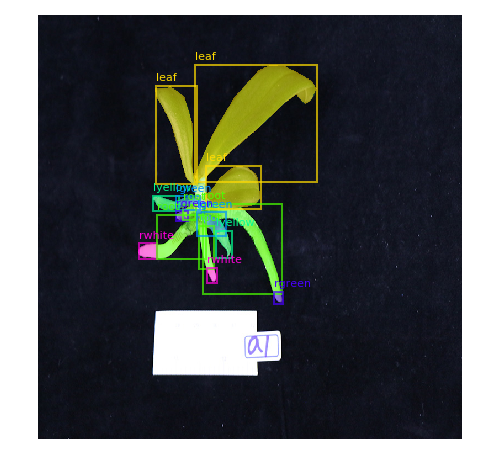

Processing 1 images
image                    shape: (768, 768, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 768, 768, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max:  768.00000  int32
anchors                  shape: (1, 147312, 4)        min:   -0.70803  max:    1.62459  float32


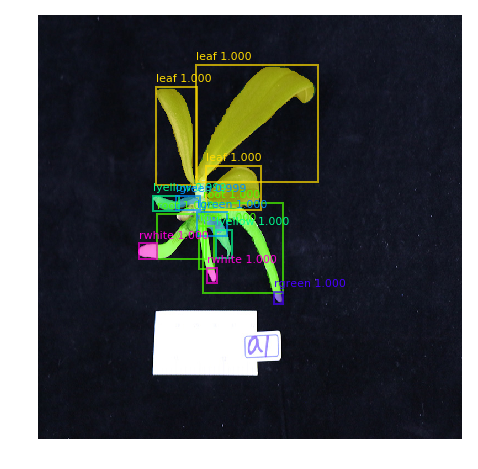

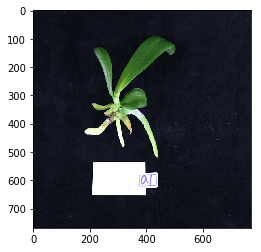

In [8]:
import skimage.io
import glob
import matplotlib.image as mpimg


class_names = ['BG','leaf','root','lyellow','lgreen','rwhite','rgreen']
#class_names = ['BG','butterfly','eyespot']
#class_names = ['BG','crack']
for i in range(1):
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset_val, config,i,use_mini_mask=False)

    log("original_image", original_image)
    log("image_meta", image_meta)
    log("gt_class_id", gt_class_id)
    log("gt_bbox", gt_bbox)
    log("gt_mask", gt_mask)

    visualize.display_instances1(original_image, gt_bbox, gt_mask, gt_class_id, 
                                class_names, figsize=(8, 8))

    results = model.detect([original_image], verbose=1)

    r = results[0]

    visualize.display_instances2(original_image, r['rois'], r['masks'],r['class_ids'], 
                                class_names, r['scores'],figsize=(8, 8))
    plt.imshow(original_image)
    plt.show()

## Evaluation

In [ ]:

# Compute VOC-Style mAP @ IoU=0.5# Comput 
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids,10)
APs = []
aps = []

#class_names = ['BG','butterfly','eyespot']
class_names = ['BG','leaf','root','lyellow','lgreen','rgreen','rwhite']
#class_names = ['BG','crack']

for image_id in range(412):
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image,config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    ap = utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,r["rois"], r["class_ids"], r["scores"], r['masks'])
    aps.append(ap)
    print(AP,precisions,recalls)
    #visualize.plot_precision_recall(AP, precisions, recalls)
    APs.append(AP)
    
#visualize.plot_precision_recall(np.mean(APs), np.mean(precisionss), np.mean(recallss))
print(np.mean(np.array(sorted(APs,reverse=True)[:82])),np.mean(np.array(sorted(aps,reverse=True)[:82])))

[ 1.  4.  5.  3.  0. 11. 12. -1. -1. -1.  2. -1. 10.  8. -1.]
[ 1.  4.  5.  3.  0. 11. 12. -1. -1. -1.  2. -1. 10.  8. -1.]
AP @0.50:	 0.606
[ 1.  4.  5.  3.  0. 11. 12. -1. -1. -1.  2. -1. 10.  8. -1.]
AP @0.55:	 0.606
[ 1.  4.  5.  3.  0. 11. 12. -1. -1. -1.  2. -1. 10.  8. -1.]
AP @0.60:	 0.606
[ 1.  4.  5.  3.  0. 11. 12. -1. -1. -1.  2. -1. 10.  8. -1.]
AP @0.65:	 0.606
[ 1.  4.  5.  3.  0. 11. 12. -1. -1. -1.  2. -1. 10.  8. -1.]
AP @0.70:	 0.606
[ 1.  4.  5.  3.  0. 11. 12. -1. -1. -1.  2. -1. 10.  8. -1.]
AP @0.75:	 0.606
[ 1.  4.  5.  3.  0. 11. 12. -1. -1. -1.  2. -1. 10.  8. -1.]
AP @0.80:	 0.606
[ 1.  4.  5.  3.  0. 11. 12. -1. -1. -1.  2. -1. 10.  8. -1.]
AP @0.85:	 0.606
[ 1.  4.  5.  3. -1. 11. 12. -1. -1. -1.  2. -1. 10.  8. -1.]
AP @0.90:	 0.462
AP @0.50-0.90:	 0.590
0.605698022322777 [1.         1.         1.         1.         1.         1.
 1.         0.85714286 0.77777778 0.77777778 0.76923077 0.76923077
 0.76923077 0.76923077 0.        ] [0.         0.06666667 0.1

([<matplotlib.axis.YTick at 0x1ea8786e320>,
 <a list of 6 Text yticklabel objects>)

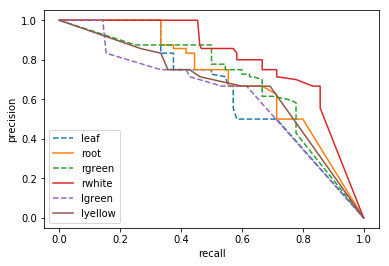

In [9]:
#print(gt_class_id)
leaf_rec = []
leaf_pre = []
root_rec = []
root_pre = []
lgreen_rec = []
lgreen_pre = []
lyellow_rec = []
lyellow_pre = []
rgreen_rec = []
rgreen_pre = []
rwhite_rec = []
rwhite_pre = []

for image_id in range(57):
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image,config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]

    AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                                  r['rois'], r['class_ids'], r['scores'], r['masks'], iou_threshold=0.7)
    vis_index = visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],overlaps, dataset_val.class_names)
    leaf_rec += [recalls[leafir] for leafir, leafnr in enumerate(vis_index) if leafnr is "leaf"]
    leaf_pre += [precisions[leafip] for leafip, leafnp in enumerate(vis_index) if leafnp is "leaf"]
    root_rec += [recalls[rootir] for rootir, rootnr in enumerate(vis_index) if rootnr is "root"]
    root_pre += [precisions[rootip] for rootip, rootnp in enumerate(vis_index) if rootnp is "root"]
    lgreen_rec += [recalls[lgreenir] for lgreenir, lgreennr in enumerate(vis_index) if lgreennr is "lgreen"]
    lgreen_pre += [precisions[lgreenip] for lgreenip, lgreennp in enumerate(vis_index) if lgreennp is "lgreen"]
    lyellow_rec += [recalls[lyellowir] for lyellowir, lyellownr in enumerate(vis_index) if lyellownr is "lyellow"]
    lyellow_pre += [precisions[lyellowip] for lyellowip, lyellownp in enumerate(vis_index) if lyellownp is "lyellow"]
    rgreen_rec += [recalls[rgreenir] for rgreenir, rgreennr in enumerate(vis_index) if rgreennr is "rgreen"]
    rgreen_pre += [precisions[rgreenip] for rgreenip, rgreennp in enumerate(vis_index) if rgreennp is "rgreen"]
    rwhite_rec += [recalls[rwhiteir] for rwhiteir, rwhitenr in enumerate(vis_index) if rwhitenr is "rwhite"]
    rwhite_pre += [precisions[rwhiteip] for rwhiteip, rwhitenp in enumerate(vis_index) if rwhitenp is "rwhite"]
    
#print(leaf_rec)
#visualize.plot_precision_recall(AP, precisions, recalls)
plt.plot(np.array(sorted(leaf_rec+[1]+[0])),np.array(sorted(leaf_pre+[0]+[1],reverse=True)),"--",label="leaf")
plt.plot(np.array(sorted(root_rec+[1]+[0])),np.array(sorted(root_pre+[0]+[1],reverse=True)),label="root")
plt.plot(np.array(sorted(rgreen_rec+[1]+[0])),np.array(sorted(rgreen_pre+[0]+[1],reverse=True)),"--",label="rgreen")
plt.plot(np.array(sorted(rwhite_rec+[1]+[0])),np.array(sorted(rwhite_pre+[0]+[1],reverse=True)),label="rwhite")
plt.plot(np.array(sorted(lgreen_rec+[1]+[0])),np.array(sorted(lgreen_pre+[0]+[1],reverse=True)),"--",label="lgreen")
plt.plot(np.array(sorted(lyellow_rec+[1]+[0])),np.array(sorted(lyellow_pre+[0]+[1],reverse=True)),label="lyellow")
plt.legend(loc="best")
plt.xlabel("recall")
plt.ylabel("precision")
plt.xticks(np.arange(0,1.2,step=0.2))
plt.yticks(np.arange(0,1.2,step=0.2))

['leaf',
 'leaf',
 'leaf',
 'root',
 'root',
 'lyellow',
 'lgreen',
 'rgreen',
 'root',
 'rwhite',
 'root',
 'rwhite',
 'lgreen',
 'lyellow',
 'rgreen']

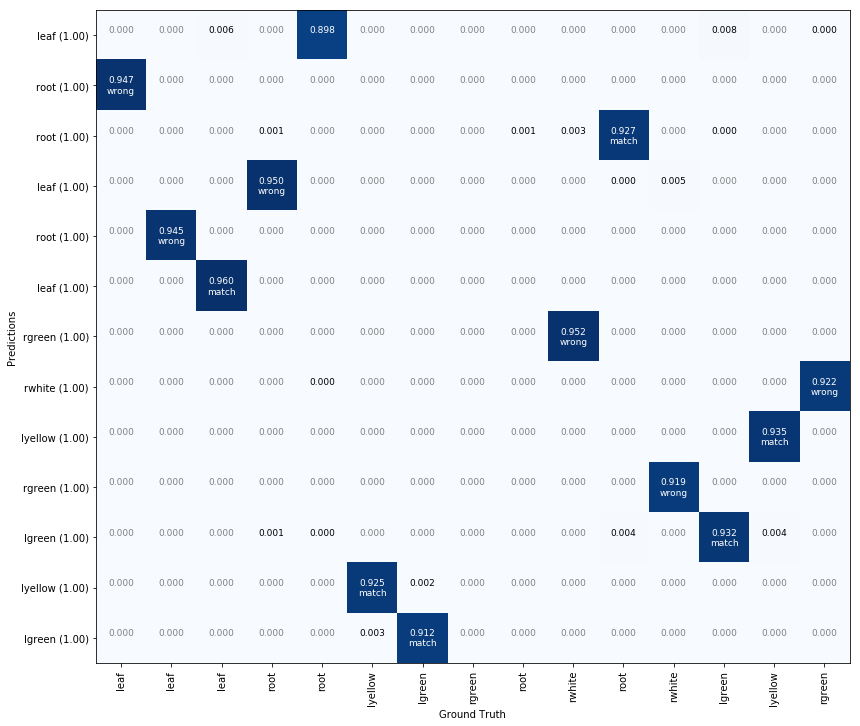

In [10]:
visualize.plot_overlaps(gt_class_id, r['class_ids'], r['scores'],
                        overlaps, dataset_val.class_names)

In [8]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, config,
                               2, use_mini_mask=False)
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )

AttributeError: 'MaskRCNN' object has no attribute 'anchors'

In [9]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

NameError: name 'positive_anchors' is not defined

In [10]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 introduces a new version of NMS. Search for both names to support TF 1.3 and 1.4
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

ResourceExhaustedError: OOM when allocating tensor with shape[1,512,192,192] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: rpn_model/rpn_conv_shared/convolution = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](fpn_p2/BiasAdd, rpn_conv_shared/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: ROI/refined_anchors/_2011 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_4226_ROI/refined_anchors", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'rpn_model/rpn_conv_shared/convolution', defined at:
  File "C:\Users\USER\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\USER\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\USER\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\USER\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\USER\Anaconda3\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\USER\Anaconda3\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\USER\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\USER\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\USER\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\USER\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\USER\Anaconda3\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\USER\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\USER\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\USER\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\USER\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\USER\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\USER\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\USER\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\USER\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-7-d954d248d4db>", line 2, in <module>
    model_dir=MODEL_DIR)
  File "F:\Mask_RCNN-master\mrcnn\model_unet.py", line 1861, in __init__
    self.keras_model = self.build(mode=mode, config=config)
  File "F:\Mask_RCNN-master\mrcnn\model_unet.py", line 1968, in build
    layer_outputs.append(rpn([p]))
  File "C:\Users\USER\Anaconda3\lib\site-packages\keras\engine\topology.py", line 619, in __call__
    output = self.call(inputs, **kwargs)
  File "C:\Users\USER\Anaconda3\lib\site-packages\keras\engine\topology.py", line 2085, in call
    output_tensors, _, _ = self.run_internal_graph(inputs, masks)
  File "C:\Users\USER\Anaconda3\lib\site-packages\keras\engine\topology.py", line 2236, in run_internal_graph
    output_tensors = _to_list(layer.call(computed_tensor, **kwargs))
  File "C:\Users\USER\Anaconda3\lib\site-packages\keras\layers\convolutional.py", line 168, in call
    dilation_rate=self.dilation_rate)
  File "C:\Users\USER\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py", line 3335, in conv2d
    data_format=tf_data_format)
  File "C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 780, in convolution
    return op(input, filter)
  File "C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 868, in __call__
    return self.conv_op(inp, filter)
  File "C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 520, in __call__
    return self.call(inp, filter)
  File "C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_ops.py", line 204, in __call__
    name=self.name)
  File "C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 1042, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3414, in create_op
    op_def=op_def)
  File "C:\Users\USER\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1,512,192,192] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: rpn_model/rpn_conv_shared/convolution = Conv2D[T=DT_FLOAT, data_format="NCHW", dilations=[1, 1, 1, 1], padding="SAME", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true, _device="/job:localhost/replica:0/task:0/device:GPU:0"](fpn_p2/BiasAdd, rpn_conv_shared/kernel/read)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[Node: ROI/refined_anchors/_2011 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_4226_ROI/refined_anchors", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



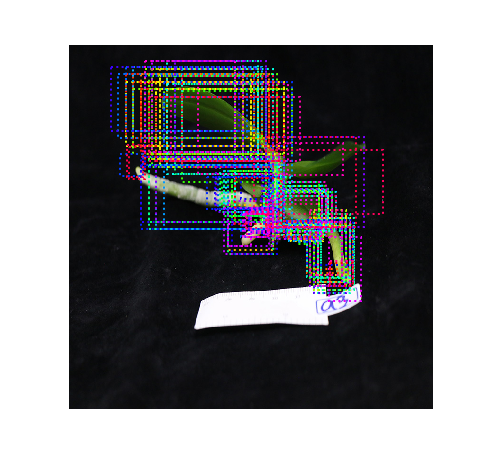

In [12]:
# Show top anchors by score (before refinement)
limit = 150
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

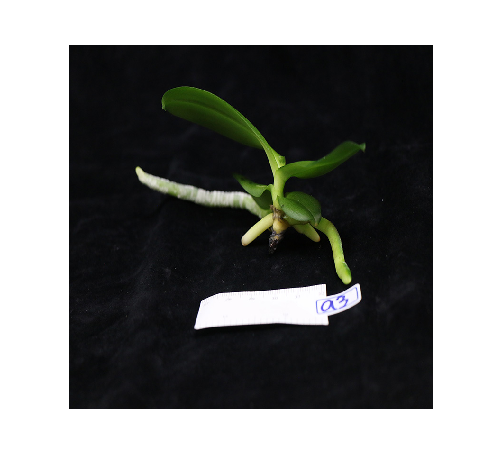

In [13]:
# Show refined anchors after non-max suppression
limit = 30
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=rpn["refined_anchors_clipped"][0, ixs], ax=get_ax())

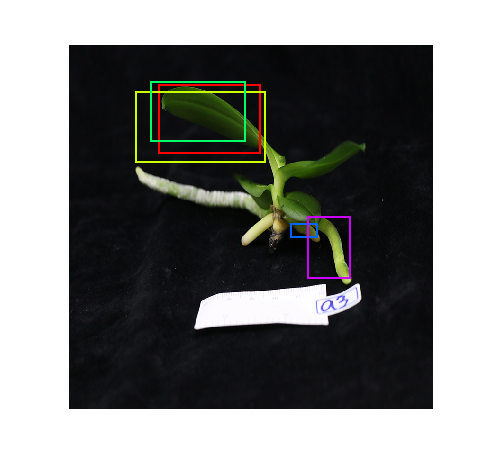

In [14]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 5
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

In [4]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

NameError: name 'model' is not defined

11 detections: ['leaf' 'root' 'root' 'rgreen' 'leaf' 'leaf' 'root' 'leaf' 'root' 'rwhite'
 'rwhite']


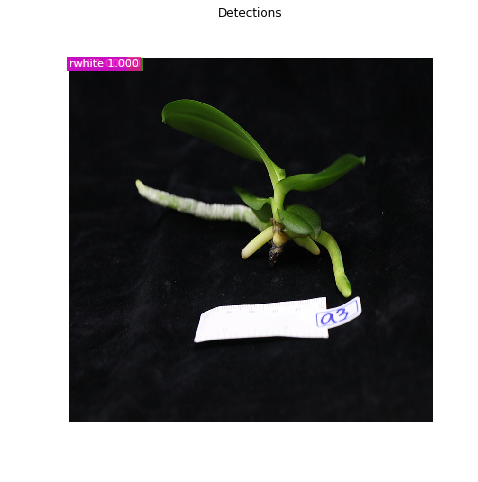

In [16]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset_val.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset_val.class_names[int(c)], s) if c > 0 else ""
            for c, s in zip(detections[:, 4], detections[:, 5])]
visualize.draw_boxes(
    image, 
    refined_boxes=detections[:, :4],
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

In [17]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset_val.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

1000 Valid proposals out of 1000
101 Positive ROIs
[('BG', 899), ('leaf', 51), ('rgreen', 5), ('root', 40), ('rwhite', 5)]


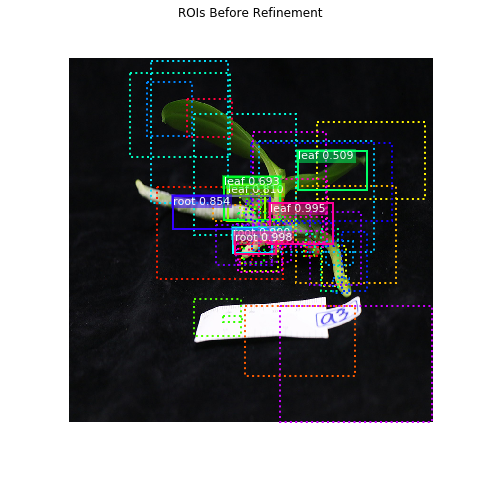

In [18]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 50
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset_val.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[ixs], roi_scores[ixs])]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

roi_bbox_specific        shape: (1000, 4)             min:   -2.18128  max:   15.53589  float32
refined_proposals        shape: (1000, 4)             min: -1105.00000  max: 2203.00000  int32


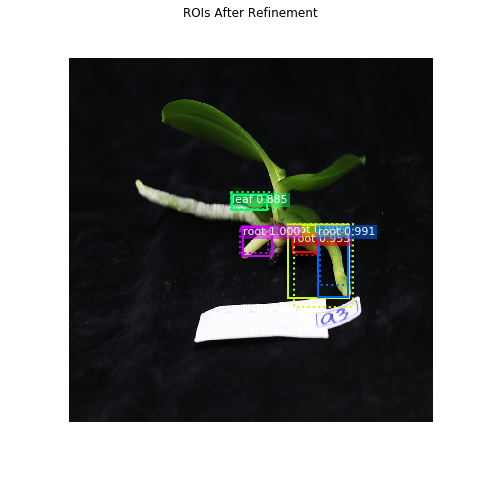

In [19]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset_val.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids])]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

In [20]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 101 detections:
[  0   1   2   3   4   5   7  12  13  15  16  17  18  19  20  22  25  26
  28  30  36  37  43  45  48  54  55  56  63  64  68  69  72  75  78  80
  84  85  99 106 107 109 114 117 126 128 142 146 154 155 161 166 176 189
 195 209 215 235 237 238 251 262 265 266 270 277 284 287 288 292 306 316
 347 355 385 386 400 405 451 525 558 574 592 605 624 637 660 665 757 780
 782 796 800 812 817 853 883 933 935 946 957]


In [21]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.7 confidence. Keep 91:
[  0   1   2   3   4   5   7  12  13  15  16  17  18  19  20  22  25  26
  28  30  36  37  43  45  48  54  55  56  63  64  68  69  72  75  78  80
  84  85  99 106 107 109 114 117 126 128 142 154 161 166 176 189 195 209
 235 237 238 251 262 265 266 270 287 288 292 306 316 347 385 386 400 405
 451 525 558 574 592 605 624 637 660 757 782 796 800 817 883 933 935 946
 957]


In [22]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in np.unique(pre_nms_class_ids):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset_val.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

leaf                  : [  0   1   2   5   7  12  13  15  16  18  19  20  25  26  30  37  48  56
  68  69  72  75  85 106 107 109 161 176 195 209 238 251 265 292 385 400
 451 574 592 796 883 957] -> [15 56 26 13]
root                  : [  3   4  17  22  28  36  43  45  55  78  80  84  99 114 117 126 128 142
 154 166 189 235 237 262 266 270 306 347 386 405 525 558 624 660 757 800
 817 935 946] -> [ 4 99 22  3]
rgreen                : [ 54 287 288 782 933] -> [54]
rwhite                : [ 63  64 316 605 637] -> [63 64]

Kept after per-class NMS: 11
[ 3  4 13 15 22 26 54 56 63 64 99]


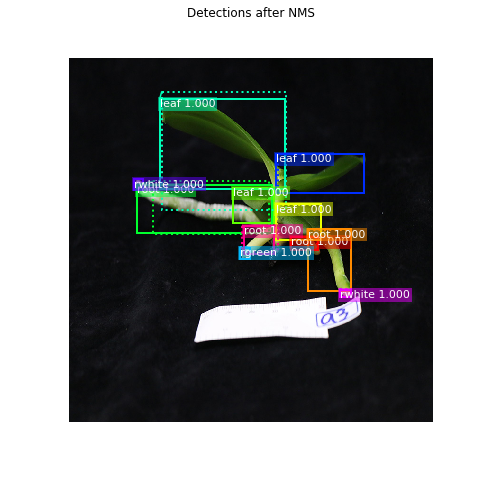

In [23]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset_val.class_names[c], s) if c > 0 else ""
            for c, s in zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs])]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

In [2]:
from mrcnn.visualize import display_images
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

C:\Users\USER\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


NameError: name 'np' is not defined

In [ ]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset_val.class_names)[det_class_ids]))

In [3]:
# Masks
det_boxes = mrcnn["detections"][0, :, :4].astype(np.int32)
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in enumerate(det_class_ids)])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in enumerate(det_mask_specific)])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

NameError: name 'mrcnn' is not defined

In [17]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

NameError: name 'display_images' is not defined

In [37]:
# Get activations of a few sample layers
activations = model.run_graph([image], [
    ("input_image", model.keras_model.get_layer("input_image").output),
    ("bn_conv1", model.keras_model.get_layer("bn_conv1").output),  # for resnet26
    ("rpn_bbox",model.keras_model.get_layer("rpn_bbox").output),
    ("roi",model.keras_model.get_layer("ROI").output),
])

input_image              shape: (1, 768, 768, 3)      min: -123.70000  max:  151.10001  float32
fpn_c5p5                 shape: (1, 24, 24, 256)      min:  -25.84520  max:   21.45743  float32
rpn_bbox                 shape: (1, 147312, 4)        min:  -14.94360  max:   18.31466  float32
roi                      shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


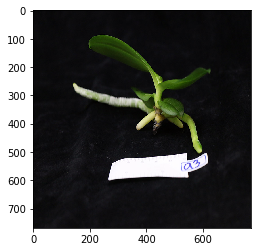

In [38]:
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

In [1]:
# Backbone feature map
#print(activations["mrcnn_mask_conv1"].shape)
display_images(np.transpose(activations["bn_conv1"][0,:,:,:400],[2, 0, 1]))
#display_images(activations["mrcnn_mask_conv1"])

NameError: name 'display_images' is not defined